# Notebook 4


Transform-based option pricing methods like the Laplace transform approach are useful tools to obtain option pricing in many different more sophisticated models because often the characteristic function of the log-stock price is known in closed form, while its density is not. The fast Fourier transform is particularly useful because it can be employed to simultaneously compute the prices of options with multiple different strike prices. In this notebook we are applying these methods to the Heston model from Section 3.5. In the code snippet below, we define the variables $r$, $\gamma(0)$, $\kappa$ $\lambda$, $\widetilde \sigma$, $\rho$, $T$ and $S(0)$ for the model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, norm, expon
from scipy.integrate import simpson, quad
from scipy.optimize import minimize

r = 0.02
sigma = 0.3
gam0 = 0.3**2
kappa = 0.3**2
lamb = 2.5
sig_tilde = 0.3
T = 1
S0 = 120
K = 100

<br><br>

## Step 1: Pricing by integration in the Heston model using the Gil-Pelaez formula

To compute values of European call and put options in the Black-Scholes model using the pricing-by-integration approach from Chapter 3, we only need to be able to integrate the probability density of the terminal stock price $S(T)$ (or of the log-stock price $X(T) = \log S(T)$). This is especially easy in the Black-Scholes model, where $X(T)$ is normally distributed- In the Heston model, the situation is not that easy because in the Heston model we do not know the density of $S(T)$ or $X(T)$ in closed form. We will now try to obtain the density of $X(T)$ by a different route using Fourier inversion that uses the fact that we explicitly know the characteristic function of $\log S(T)$ in the Heston model.

The code snippet below contains a function `heston_char` that computes the characteristic function $\chi(u)$ of $\log S(T)$ in the Heston model with parameters $\kappa$, $\lambda$, $\widetilde \sigma$, initial variance $\gamma(0)$, initial stock price $S(0)$ and risk-free interest rate $r$ as in equation (4.8) in the lecture notes.

In [2]:
def heston_char(u, S0, T, r):
    d = np.sqrt(lamb ** 2 + sig_tilde ** 2 * (u * 1j + u ** 2))
    phi = np.cosh(0.5 * d * T)
    psi = np.sinh(0.5 * d * T) / d
    first_factor = (np.exp(lamb * T / 2) / (phi + lamb * psi))**(2 * kappa / sig_tilde ** 2)
    second_factor = np.exp(-gam0 * (u * 1j + u ** 2) * psi / (phi + lamb * psi))
    return np.exp(u * 1j * (np.log(S0) + r * T)) * first_factor * second_factor

From the characteristic function $\chi_0(u)$ of $X(T)$ one can now compute the probability density function (pdf) $f$ of $X(T)$ using the so-called *Gil-Pelaez formula*:
\begin{equation} f(x) = \frac{1}{\pi} \int_0^\infty \mathrm{Re}\Big(e^{-iux} \chi_0(u)\Big) du. \end{equation}

**Task 1.1**: Use a for-loop to compute the values $f(x)$ using the Gil-Pelaez formula for $x$ taking 1000 equally spaced values between 3.5 and 6 (already defined as an array `x_array` below). Store the pdf values in an array `dens`. Use the parameter values $\gamma(0) = 0.3^2$, $\kappa = 0.3^2$, $\lambda = 2.5$ and $\widetilde \sigma = 0.3$ and use the variables `r`, `S0` and `T` as before.

*Useful Python commands*: The integral $\int_a^b f(u) du$ can be computed using the scipy.integrate command `quad(f, a, b)[0]`. Use $a=0$ and $b=50$ in the Gil-Pelaez formula to avoid numerical difficulties.

In [7]:
# x_array = ...
# dens = ...
# for i, x in enumerate(x_array):
#     ...
#     dens[i] = ...

In [4]:
x_array = np.linspace(3.5, 6, 1000)
dens = np.zeros(1000)

for i, x in enumerate(x_array):
    def integrand(u):
        return np.real(np.exp(-1j * u * x) * heston_char(u, S0, T, r))
    dens[i] = (1/np.pi) * quad(integrand, 0, 50)[0]

**Task 1.2**: Plot the pdf values $f(x)$ from the array `dens` against the values of $x$ from the array `x_array`.

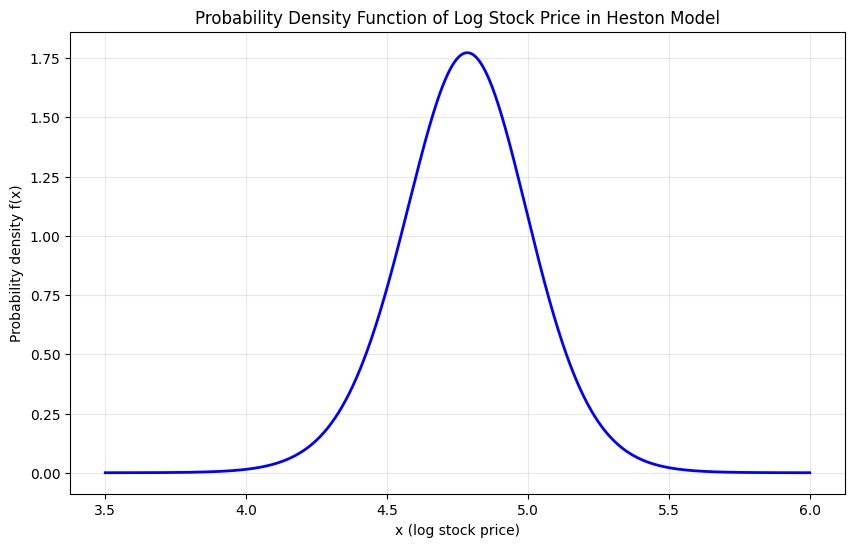

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(x_array, dens, 'b-', linewidth=2)
plt.xlabel('x (log stock price)')
plt.ylabel('Probability density f(x)')
plt.title('Probability Density Function of Log Stock Price in Heston Model')
plt.grid(True, alpha=0.3)
plt.show()

Since we now have computed the pdf $f$ of $X(T)$, we can now use the pricing-by-integration approach from pp. 26-27 in the lecture notes. In other words, the goal is to numerically compute the integral
\begin{equation} V(0) = B(0) E_Q(g(S(T))/B(T)) = e^{-rT} \int_{-\infty}^\infty g(e^x) f(x) dx, \end{equation}
where $g$ is the payoff function of the option contract under consideration. Since however we only have 1000 discrete samples of the integrand above, we cannot use the scipy function `quad` to compute the above integral.

**Task 1.3**: Define an array `integrand` of length 1000 that contains the values of the integrand $g(e^x) f(x)$ for $x$ taking values in the array `x_array` and $g$ being the payoff of a European call option with strike $K = 100$. Then, use the scipy.integrate function `simpson` to approximate the above integral from the 1000 equidistant samples of the integrand. Store the resulting option price in a variable `call_Heston_int` and print it to the console.

In [ ]:
...
integrand = ...
call_Heston_int = ...
print('Heston call price using the Gil-Pelaez formula: {:.4f}'.format(call_Heston_int))

In [8]:
# Call option payoff function: max(S(T) - K, 0) = max(e^x - K, 0)
integrand = np.maximum(np.exp(x_array) - K, 0) * dens
call_Heston_int = np.exp(-r * T) * simpson(integrand, x_array)
print('Heston call price using the Gil-Pelaez formula: {:.4f}'.format(call_Heston_int))

Heston call price using the Gil-Pelaez formula: 24.7230


<br>

## Step 2: Computation of call option prices in the Black-Scholes model via Monte Carlo methods

Since option prices are expected values of the form $V(0) = E_Q(e^{-rT} f(S(T))$, we can approximate the expectation on the right-hand side by Monte Carlo simulation. We now want to visualize the convergence of the Monte Carlo estimator for price $V(0)$ of a European call option with strike $K = 100$ and $T=1$ in the Black-Scholes model with volatility $\sigma=0.3$, initial stock price $S(0)=120$ and risk-free interest rate $r=0.02$ with $M=20$ different trajectories. We want to use up to $N = 10\,000$ simulations of $S(T)$ per trajectory.

**Task 2.1**: Define variables `N` and `M` as specified above. Then, draw $M \times N$ samples of a standard normal distribution and store them in an array `x_rand`. Use the numpy random seed 20 for reproducibility. Finally, compute the 20 different Monte Carlo estimators $\widehat V_N$ (one estimator for each row of `x_rand`) and store them in an array `estimates_N`. Plot the Monte Carlo estimates using the prepared code snippet.

*Useful Python commands*: `np.random.normal`

In [ ]:
...
plt.show()

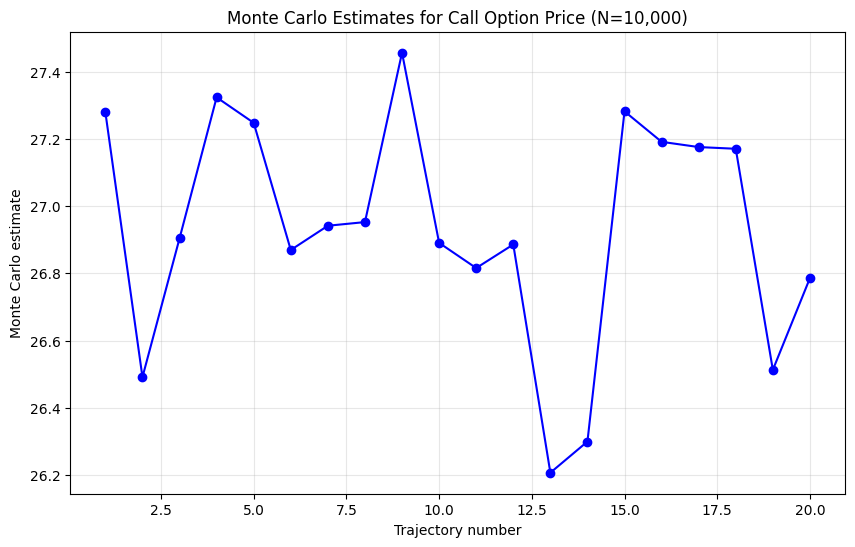

In [9]:
N = 10000
M = 20
np.random.seed(20)
x_rand = np.random.normal(0, 1, (M, N))
# Compute S(T) for each simulation
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * x_rand)
# Compute call payoffs
payoffs = np.maximum(S_T - K, 0)
# Monte Carlo estimates (one for each trajectory)
estimates_N = np.exp(-r * T) * np.mean(payoffs, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(range(1, M+1), estimates_N, 'bo-', markersize=6)
plt.xlabel('Trajectory number')
plt.ylabel('Monte Carlo estimate')
plt.title('Monte Carlo Estimates for Call Option Price (N=10,000)')
plt.grid(True, alpha=0.3)
plt.show()

Instead of only computing twenty different Monte Carlo estimators using $N = 10\,000$ samples, we now want to visually see how the 20 Monte Carlo estimators behave when the number $n$ of samples is varied between $100$ and $N = 10\,000$. We will obtain twenty different *trajectories* of Monte Carlo estimators that should all converge to the true option price as $n$ gets larger.

**Task 2.2.**: Define an array `n` that takes all integer values between $100$ an $N$. Then, define an array `estimates` of shape `(M, N - 99)`. Each row of the array `estimates` is supposed to contain one of the twenty trajectories of Monte Carlo estimators with the number of samples $n$ varying between $100$ and $N$. In other words, the entry `estimates[i, j]` should contain the Monte Carlo estimator $\widehat V_{100 + j}$ of $V(0)$ using the only the simulated elements `x_rand[i, :(99+j)]`.

*Useful Python commands*: `np.arange`, `np.random.normal`, `np.cumsum`

In [11]:
# n = ...
# estimates = ...

In [12]:
n = np.arange(100, N + 1)
estimates = np.zeros((M, N - 99))

# For each trajectory (row) and each sample size
for i in range(M):
    cumsum_payoffs = np.cumsum(payoffs[i, :])
    for j, sample_size in enumerate(n):
        estimates[i, j] = np.exp(-r * T) * cumsum_payoffs[sample_size - 1] / sample_size

We now want to compare the Monte Carlo estimate option price to the true option price, computed by the Black-Scholes formula.

**Task 2.3**: Copy your function `european_BS(t, St, K, T, r, sigma, call)` that computes European option prices in the Black-Scholes model from Task 1.5 of the Week 03 notebook, or write it from scratch if you did not complete that task from week 03. Afterwards, compute the true value of the considered call option price and store it in a variable `true_val`.

In [16]:
# def european_BS(t, St, K, T, r, sigma, call):
#     ...

# true_val = ...

In [17]:
def european_BS(t, St, K, T, r, sigma, call):
    from scipy.stats import norm
    tau = T - t
    if tau <= 0:
        if call:
            return max(St - K, 0)
        else:
            return max(K - St, 0)
    d1 = (np.log(St / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    if call:
        return St * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    else:
        return K * np.exp(-r * tau) * norm.cdf(-d2) - St * norm.cdf(-d1)
    
true_val = european_BS(0, S0, K, T, r, sigma, True)
print(f'True Black-Scholes call price: {true_val:.4f}')

True Black-Scholes call price: 26.8034


One can show that the variance of the discounted payoff $e^{-rT} (S(T) - K)^+$ under $Q$ is approximately $\mathrm{Var}_Q[e^{-rT} (S(T) - K)^+] \approx 1003$. Therefore, the standard deviation of the Monte Carlo estimator with $n \in \{100, \dots, N\}$ samples is approximately given by $\sigma(\widehat V_n) \approx \sqrt{\frac{1003}{n}}$ (see equation (5.2) in the lecture notes). An approximate 95% confidence interval for the Monte Carlo estimate $\widehat V_n$ is therefore given by $\big[V(0) - 1.96 \sqrt{\frac{1003}{n}}, \; V(0) + 1.96 \sqrt{\frac{1003}{n}}\big]$.

**Task 2.4**: Use the array `n` defined in Task 2.2 to compute the above 95% confidence for all the Monte Carlo estimates from the array `estimates` centered at the true value. Store the lower confidence interval boundaries in an array `c_lower` and the upper confidence interval boundaries in an array `c_upper`.

*Useful Python commands*: `np.sqrt`

In [19]:
# sigma_sq = 1003
# c_lower = ...
# c_upper = ...

In [20]:
sigma_sq = 1003

c_lower = true_val - 1.96 * np.sqrt(sigma_sq / n)
c_upper = true_val + 1.96 * np.sqrt(sigma_sq / n)

**Task 2.5**: Plot the 20 trajectories of Monte Carlo estimates from the array `estimates` against the number of sample paths from the array `n`. Additionally draw the upper and lower confidence interval boundaries from the arrays `c_lower` and `c_upper` into the same plot window. Finally, use the function `plt.axhline` to draw a horizontal line at the true option value `true_val` and interpret your result using a comment.

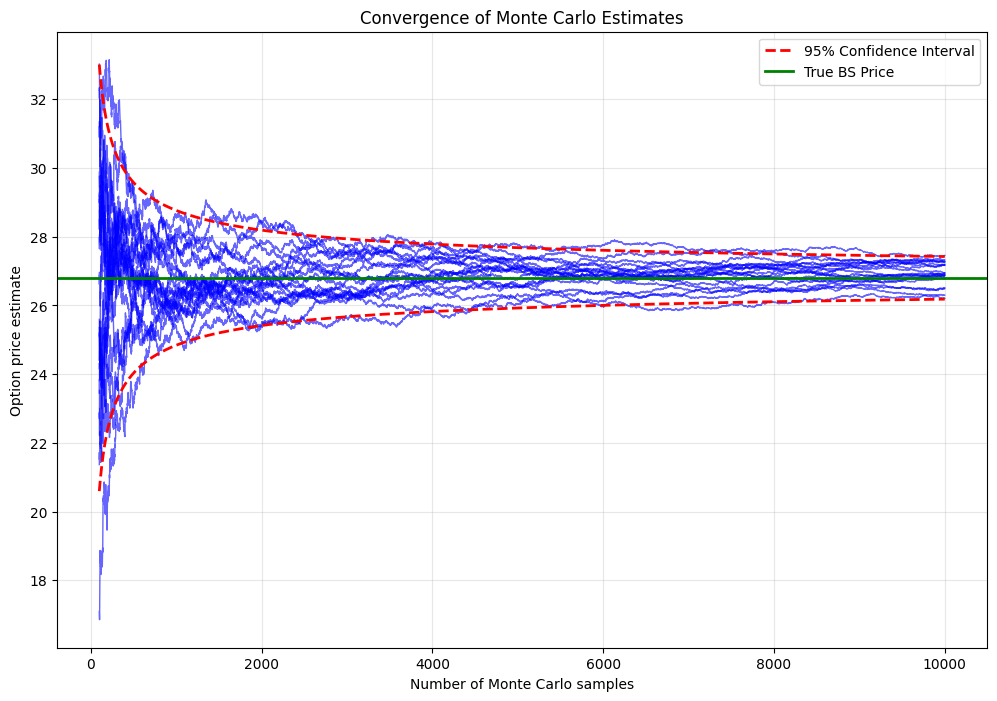

In [21]:
plt.figure(figsize=(12, 8))
# Plot all 20 trajectories\n",
for i in range(M):
    plt.plot(n, estimates[i, :], 'b-', alpha=0.6, linewidth=1)
# Plot confidence intervals\n",
plt.plot(n, c_upper, 'r--', linewidth=2, label='95% Confidence Interval')
plt.plot(n, c_lower, 'r--', linewidth=2)
# Plot true value
plt.axhline(y=true_val, color='g', linestyle='-', linewidth=2, label='True BS Price')
plt.xlabel('Number of Monte Carlo samples')
plt.ylabel('Option price estimate')
plt.title('Convergence of Monte Carlo Estimates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Comment: The Monte Carlo estimates converge to the true Black-Scholes price as the number of samples increases.Most trajectories stay within the 95% confidence interval, demonstrating the expected statistical behavior
  

<br><br>

## Step 3: Computation of chooser option prices in the Black-Scholes model via Monte Carlo methods

A chooser option with expiry at time $T$ and strike $K$ is an option contract that grants the holder of the option the possibility to choose at some prespecified time $t^∗ \in (0, T)$ whether the option should be a call option or a put option with strike $K$. Our goal is now to use Monte Carlo methods to compute the price $V(0)$ of a chooser option with expiry at time $T=1$ and strike $K=100$ in the Black-Scholes model and compare it with the theoretical true value. In our case, the choosing time is set to $t^* = 0.5$. If at this time point the theoretical price of a European call option with expiry at $T$ is higher than the theoretical price of a European put option with expiry at $T$, then the holder of the chooser option will decide that it will be a call option at expiry, and vice versa.

The code snippet below imports $N = 10\,000$ independent paths of a geometric Brownian motion $S(t) = S(0) \exp((r - \sigma^2 / 2) t + \sigma W(t))$ with $r = 0.02$ and $\sigma = 0.3$ at the $M = 1000$ time points $t = t_i = 0, \frac{1}{1000}, \frac{2}{1000}, \dots, \frac{999}{1000}, 1$.

In [23]:
t_star = 0.5
stock_paths = np.loadtxt('data/GBM_paths.csv')
N = stock_paths.shape[0]
M = stock_paths.shape[1]
print(stock_paths.shape)

(10000, 1001)


To compute chooser option prices via Monte Carlo methods, we have to check for each of the $N = 10\,000$ stock price paths whether a European call option or a European put option with expiry at $T=1$ is higher at time $t^* = 0.5$. If the call option price is higher, then the chooser option will also be a call at expiry, if the put option price is higher, then the chooser option will be a put at expiry.

**Task 3.1**: Use your function `european_BS` to compute the call option prices at time $t^*=0.5$ for each of the $N=10\,000$ stock price paths with $r=0.02$ and $\sigma=0.3$. Store the resulting call prices in an array `call_prices_mid`. Repeat this for the put option prices at time $t^*=0.5$ and store them in an array `put_prices_mid`.

In [25]:
# call_prices_mid = ...
# put_prices_mid = ...

In [26]:
# Find the index corresponding to t* = 0.5\
t_star_index = int(t_star * (M - 1))  # M-1 because we have M time points from 0 to 1
call_prices_mid = np.zeros(N)
put_prices_mid = np.zeros(N)
for i in range(N):
    S_mid = stock_paths[i, t_star_index]
    call_prices_mid[i] = european_BS(t_star, S_mid, K, T, r, sigma, True)
    put_prices_mid[i] = european_BS(t_star, S_mid, K, T, r, sigma, False)

**Task 3.2**: Initialize an array `payoffs` of length $N = 10\,000$ that contains only zeros. Then, at the indices of all stock price paths for which the call price at $t^*=0.5$ is higher than the put price, set the corresponding element in the array `payoffs` to the payoff of a European call option at time $T=1$ with strike $K$. Likewise, at the indices of all stock price paths for which the put price at $t^*=0.5$ is higher than the call price, set the corresponding element in the array `payoffs` to the payoff of a European put option at time $T=1$ with strike $K$.

*Useful Python commands*: `np.zeros`, `np.maximum`

In [27]:
# payoffs = np.zeros(N)
# ...

In [28]:
payoffs = np.zeros(N)
# Final stock prices at T=1
S_final = stock_paths[:, -1]
# Choose call if call price > put price at t*
call_chosen = call_prices_mid > put_prices_mid
put_chosen = ~call_chosen
# Set payoffs accordingly
payoffs[call_chosen] = np.maximum(S_final[call_chosen] - K, 0)
payoffs[put_chosen] = np.maximum(K - S_final[put_chosen], 0)

**Task 3.3**: Compute the Monte Carlo estimate $\widehat V_N$ of the chooser option price as the discounted average of all the payoffs in the array `payoffs` and store it in a variable `chooser_price`. Afterwards, compute the sample variance $\widehat \sigma^2_N(f(X))$ of the discounted payoffs (see equation (5.5) in the lecture notes) and store it in a variable `sigma_sq`. Compute also the lower and upper boundary of an approximate 95% confidence interval $[\widehat V_n - 1.96 \sqrt{\widehat \sigma^2_N(f(X)) / N},\; \widehat V_n + 1.96 \sqrt{\widehat \sigma^2_N(f(X)) / N}]$ of the chooser option price and store them in variables `c_lower` and `c_upper`.

*Useful Python commands*: `np.exp`, `np.mean`, `np.var`, `np.sqrt`.

In [29]:
# chooser_price = ...
# sigma_sq = ...
# c_lower = ...
# c_upper = ...

In [30]:
# Discounted payoffs
discounted_payoffs = np.exp(-r * T) * payoffs
chooser_price = np.mean(discounted_payoffs)
sigma_sq = np.var(discounted_payoffs, ddof=1)  # Sample variance
c_lower = chooser_price - 1.96 * np.sqrt(sigma_sq / N)
c_upper = chooser_price + 1.96 * np.sqrt(sigma_sq / N)

**Task 3.4**: Use your function `european_BS` and the result from theoretical Exercise 02.2 to compute the true theoretical price of the chooser option in the Black-Scholes model and store it in a variable `true_price`. Afterwards, print the Monte Carlo estimate `chooser_price`, the confidence interval [`c_lower`, `c_upper`] and the true price `true_price`.

In [31]:
# true_price = ...
# print('MC chooser option price: {:.3f}, 95%-CI: [{:.3f}, {:.3f}], True price: {:.3f}'.format(chooser_price, c_lower, c_upper, true_price))

In [32]:
# From theoretical Exercise 02.2: Chooser option price = Call(S0, K, T) + Put(S0, K*exp(-r*(T-t*)), t*)
call_T = european_BS(0, S0, K, T, r, sigma, True)
put_t_star = european_BS(0, S0, K * np.exp(-r * (T - t_star)), t_star, r, sigma, False)
true_price = call_T + put_t_star
print('MC chooser option price: {:.3f}, 95%-CI: [{:.3f}, {:.3f}], True price: {:.3f}'.format( chooser_price, c_lower, c_upper, true_price))

MC chooser option price: 28.770, 95%-CI: [28.175, 29.365], True price: 28.888


<br>

## Step 4: Random number generation via inversion

Generating random numbers from a distribution with cumulative distribution function (cdf) $F$ is straightforward using the inversion method if the inverse function $F^{-1}$ is known in closed form. We now want to apply the inversion method to simulate $N = 1000$ independent samples of a *Rayleigh distribution* with scale parameter $\sigma = 3$. A Rayleigh distribution $\mathrm{Ray}(\sigma)$ with scale parameter $\sigma$ has the probability density function (pdf) $f(x) = (x/\sigma^2) e^{-\frac{x^2}{2\sigma^2}}$ and the cdf $F(x) = 1 - e^{-\frac{x^2}{2\sigma^2}}$ for $x \in [0, \infty)$. The inverse of this cdf is given by $F^{-1}(u) = \sqrt{-2 \sigma^2 \log(1 - u)}$ for $u \in [0, 1)$.

In the code snippet below, we initialized an instance of a `rayleigh` object with scale 3 from the scipy.stats module. It will be used in the following tasks to compute the pdf of a Rayleigh distribution with scale parameter $\sigma = 3$.

**Task 4.1**: Draw $N = 1000$ samples from the uniform distribution on $[0, 1]$ and store them in an array `U`. Use the numpy random seed 20 to get comparable results. Then, transform these random variables using the inverse cdf of the target Rayleigh distribution to obtain samples from it and store these in an array `rayleigh_samples`.

*Useful Python commands*: `np.random.uniform`

In [33]:
sigma_scale = 3
N = 1000
f = rayleigh(scale=sigma_scale)

np.random.seed(20)
U = np.random.uniform(0, 1, N)
rayleigh_samples = np.sqrt(-2 * sigma_scale**2 * np.log(1 - U))

**Task 4.2**: Draw a histogram of the samples `rayleigh_samples` with 30 bins. Then, initialize an array `x_array` that contains 1000 equally spaced values between 0 and 12 and use the method `f.pdf(...)` of your `rayleigh` object from Task 4.1 on the `x_array` to compute the pdf of the $\mathrm{Ray}(3)$ distribution on $(0, 12)$ and plot it in the same plot window.

*Useful Python commands*: `plt.hist`. Specify the argument `density=True` in the `plt.hist` function to get a histogram that has heights compatible with the pdf.

In [ ]:
x_array = ...
...
plt.show()

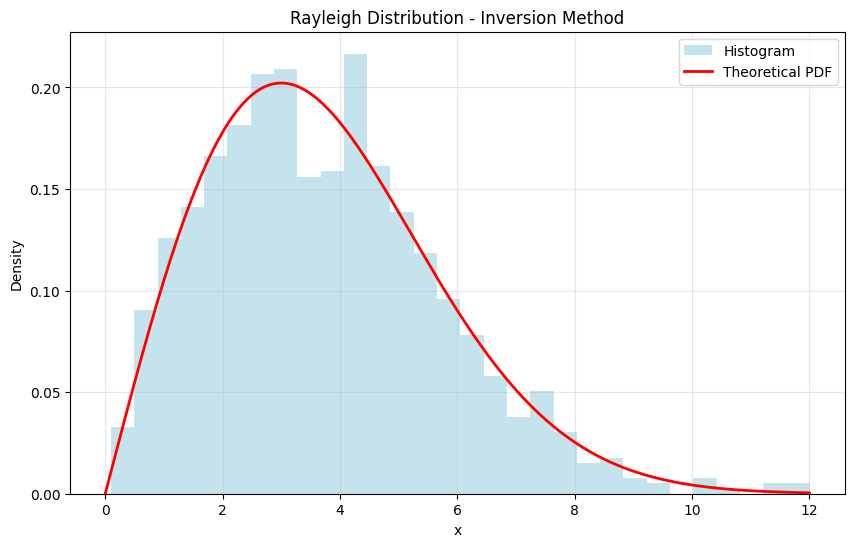

In [34]:
x_array = np.linspace(0, 12, 1000)
plt.figure(figsize=(10, 6))
plt.hist(rayleigh_samples, bins=30, density=True, alpha=0.7, color='lightblue', label='Histogram')
plt.plot(x_array, f.pdf(x_array), 'r-', linewidth=2, label='Theoretical PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Rayleigh Distribution - Inversion Method')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In some applications, one has just access to values $F(x_i)$ of the cdf of a distribution for equidistant values $x_1 < x_2 < \dots < x_n$ without knowing the inverse cdf analytically. In these cases, one can still numerically approximate the inverse cdf by linear interpolation: Suppose you want to evaluate $F^{-1}(u)$ for some $F(x_1) \leq u \leq F(x_n)$. Then, one can find $x_{i-1}$ and $x_i$ such that $F(x_{i-1}) \leq u \leq F(x_i)$ and approximate $F^{-1}(u)$ by linearly interpolating $x_{i-1}$ and $x_i$, i.e. by \begin{equation}\frac{x_{i-1} (F(x_i) - u) + x_i (u - F(x_{i-1}))}{F(x_i) - F(x_{i-1})}.\end{equation}

**Task 4.3**: Write a function `inverse_sampling(x_array, F, N)` takes as inputs an array `x_array`of equidistant points $x_i$ as well as an array `F` of corresponding cdf values $F(x_i)$ and uses the above methodology to draw $N$ samples from the distribution with cdf $F$. Your function should first draw $N$ samples from the uniform distribution on $[0, 1]$ and then use the function `np.interp` to perform the above interpolation.

*Useful Python commands*: To linearly interpolate the values $y_i = f(x_i)$ with $y_i$ and $x_i$ given by arrays `y` and `x`, respectively, onto some values $x_i^*$ given in an array `x_target`, one can use the command `np.interp(x_target, x, y)`.

In [35]:
# def inverse_sampling(x_array, F, N):
#     U = ...
#     return np.interp(...)

In [36]:
def inverse_sampling(x_array, F, N):
    np.random.seed(20)
    U = np.random.uniform(0, 1, N)
    return np.interp(U, F, x_array)

**Task 4.4**: The code snippet below contains an array `F` with values $F(x_i)$, where $x_i$ are the equally spaced values from the array `x_array` and $F$ is the cdf of the $\mathrm{Ray}(3)$ distribution. Draw 1000 samples of the $\mathrm{Ray}(3)$ distribution using the array `F` together with your function `inverse_sampling` from Task 4.3 and repeat Task 4.2 with these new samples. 

In [37]:
# F = 1 - np.exp(-x_array**2 / (2 * sigma_scale**2))

# ...
# plt.show()

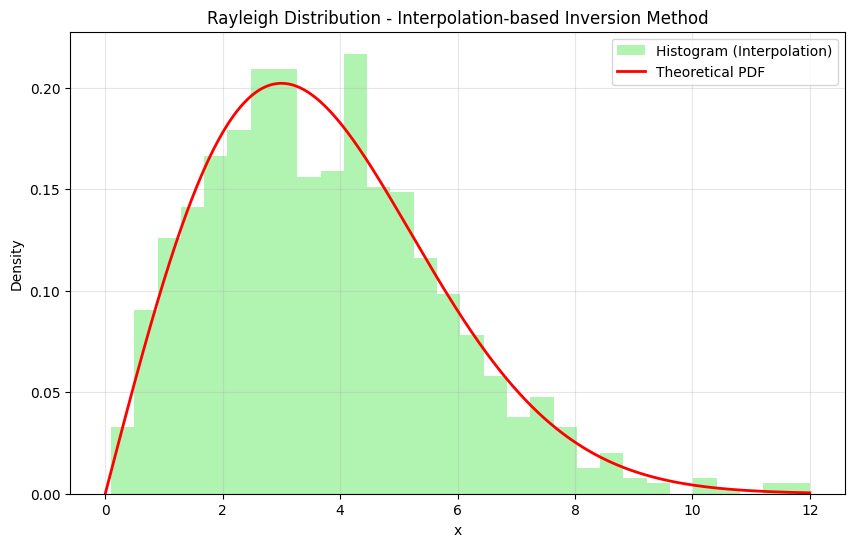

In [38]:
F = 1 - np.exp(-x_array**2 / (2 * sigma_scale**2))
rayleigh_samples_interp = inverse_sampling(x_array, F, N)
plt.figure(figsize=(10, 6))
plt.hist(rayleigh_samples_interp, bins=30, density=True, alpha=0.7, color='lightgreen', label='Histogram (Interpolation)')
plt.plot(x_array, f.pdf(x_array), 'r-', linewidth=2, label='Theoretical PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Rayleigh Distribution - Interpolation-based Inversion Method')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

<br>

## Step 5: Random number generation via the acceptance/rejection method

When the pdf of a distribution that one wants to sample from is known analytically, one can apply the acceptance/rejection method to sample from that distribution. We now want to apply this method to sampling from the $\mathrm{Ray}(3)$ distribution. Let $f$ denote the density of the $\mathrm{Ray}(3)$ distribution and let $g$ be the auxiliary density of an $\mathrm{Exp}(1)$ distribution, an exponential distribution with parameter 1. In the code snippet below, we initialize an instance of an `expon` object from the scipy.stats module that represents this distribution. We then have to find a suitable constant $C$ such that $f(x) \leq C g(x)$. Since $C$ is supposed to be not too large, we want to take the smallest possible value $C$ that satisfies this inequality. This smallest possible value is given by $C = \max_x \frac{f(x)}{g(x)}$ and is determined numerically in the code snippet below (we compute it as $C = - \min_x -\frac{f(x)}{g(x)}$ because scipy is only able to numerically minimize a function).

In [39]:
g = expon(scale=1)
C = -minimize(lambda x: -f.pdf(x) / g.pdf(x), x0=1).fun

**Task 5.1**: We now want to perform the acceptance/rejection method. Fill in the blank spaces in the code below that is supposed to draw $N$ samples from the $\mathrm{Ray}(3)$ distribution with pdf $f$. The variable `num_trials` is supposed to count the total number of simulated random variables $Y$ (no matter whether they were rejected or accepted as a simulation of $X \sim \mathrm{Ray}(3)$) that were necessary to obtain $N$ samples from the $\mathrm{Ray}(3)$ distribution.

*Useful Python commands*: A single random variable with target density $g$ can be simulated using the command `g.rvs()`. The pdf's $f(\dots)$ and $g(\dots)$ can be evaluated using `f.pdf(...)` and `g.pdf(...)`, respectively.

In [41]:
# num = 0
# num_trials = 0
# samples_accrec = np.zeros(N)

# np.random.seed(20)
# while ...:
#     Y = g.rvs()
#     U = ...
#     if U <= f.pdf(Y) / (C * g.pdf(Y)):
#         samples_accrec[num] = Y
#         num += 1
#     num_trials += 1

# print('Necessary number of simulated random variables Y: {}'.format(num_trials))

In [42]:
num = 0
num_trials = 0
samples_accrec = np.zeros(N)
np.random.seed(20)
while num < N:
    Y = g.rvs()
    U = np.random.uniform(0, 1)
    if U <= f.pdf(Y) / (C * g.pdf(Y)):
        samples_accrec[num] = Y
        num += 1
    num_trials += 1
print('Necessary number of simulated random variables Y: {}'.format(num_trials))

Necessary number of simulated random variables Y: 96048


**Task 5.2**: Repeat Task 4.2 for the samples in the array `samples` from Task 5.1, obtained via the acceptance/rejection method.

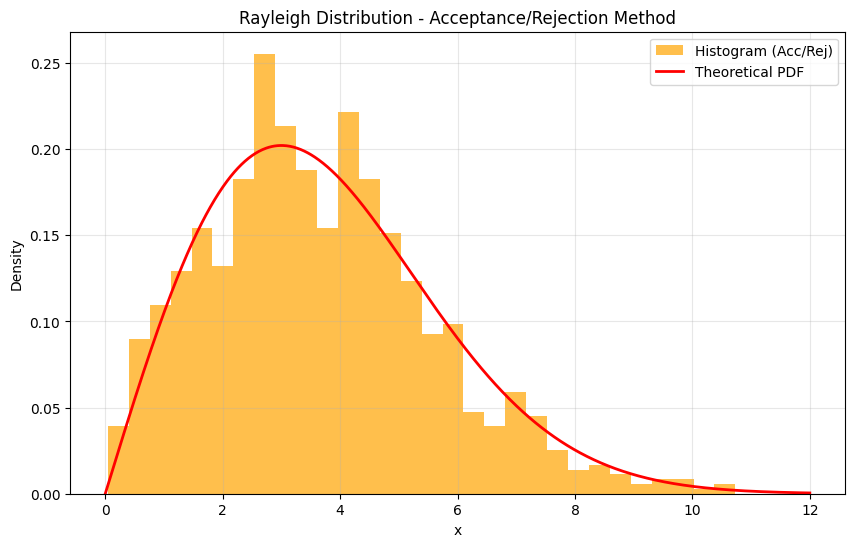

In [43]:
plt.figure(figsize=(10, 6))
plt.hist(samples_accrec, bins=30, density=True, alpha=0.7, color='orange', label='Histogram (Acc/Rej)')
plt.plot(x_array, f.pdf(x_array), 'r-', linewidth=2, label='Theoretical PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Rayleigh Distribution - Acceptance/Rejection Method')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Task 5.3**: Write a function `sample_acc_rec(f, g, N)` that performs the whole acceptance/rejection method in total. The function should receive input arguments `f` and `g` that stand for the target distribution and the auxiliary distribution, respectively (`f` should be callable with method `f.pdf(...)` and `g` should be callable with methods `g.pdf(...)` and `g.rvs()` in order for the code from Task 5.1 to work), as well as an input argument `N` for the desired number of samples. It should first determine the value of `C` as above an then perform the while-loop as in Task 5.1. It should then return both the simulated samples as well as the total number of simulated random variables $Y$. 

In [ ]:
def sample_acc_rej(f, g, N):
    ...
    return ...

In [44]:
def sample_acc_rej(f, g, N):
    # Find optimal constant C
    C = -minimize(lambda x: -f.pdf(x) / g.pdf(x), x0=1).fun
    num = 0
    num_trials = 0
    samples = np.zeros(N)
    
    while num < N:
        Y = g.rvs()
        U = np.random.uniform(0, 1)
        
        if U <= f.pdf(Y) / (C * g.pdf(Y)):
            samples[num] = Y
            num += 1
        num_trials += 1
    return samples, num_trials

If you worked with the numpy random seed 20 in Task 5.1, you should be able to see that a total of $96\,048$ simulations of a random variable $Y \sim \mathrm{Exp}(1)$ where necessary to obtain only 1000 samples of the $\mathrm{Ray}(3)$ distribution. Computationally, this is highly inefficient. The reason for this is that the $\mathrm{Exp}(1)$ distribution is not a very suitable auxiliary distribution to sample from the $\mathrm{Ray}(3)$ distribution.

From the calculations on page 52 in the lecture notes one can see that the probability of accepting a simulation $Y \sim g$ as a simulation of $X \sim f$ (i.e. the probability $P(U \leq f(Y)/(Cg(Y)))$ is given by $1 / C$. To make the acceptance/rejection method efficient, we want to reject as few samples $Y$ as possible, so we want the probability $1 / C$ to be large, or in other words, we want $C$ to be as small as possible. In the code above, we determined the optimal value of $C$ for the distribution $\mathrm{Exp}(1)$ with density $g$ as $\max_x \frac{f(x)}{g(x)}$. Now we want to find the smallest possible value of these constants $C$ by varying the scale parameter $s$ of the $\mathrm{Exp}(s)$ distribution. In other words, if $g_s$ denotes the density of the $\mathrm{Exp}(s)$ distribution, we want to determine $s = \mathrm{arg} \min_{s > 0} \max_x \frac{f(x)}{g_s(x)}$.

**Task 5.4**: Determine the above optimal $s$ using the scipy function `minimize`, store it in a variable `scale_opt` and print it.

*Useful Python commands*: The optimum $\max_x \frac{f(x)}{g_s(x)}$ can be computed using the scipy.optimize command `-minimize(lambda x: -f.pdf(x) / expon(scale=s).pdf(x), x0=1).fun`.

In [45]:
# ...
# scale_opt = ...
# ...

In [47]:
def objective(s):
    g_s = expon(scale=s)
    
    return -minimize(lambda x: -f.pdf(x) / g_s.pdf(x), x0=1).fun
    
result = minimize(objective, x0=1)
    
scale_opt = result.x[0]
    
print(f'Optimal scale parameter: {scale_opt:.4f}')
    
print(f'Corresponding optimal C: {result.fun:.4f}')

Optimal scale parameter: 4.2426
Corresponding optimal C: 2.0000


**Task 5.5**: Use your function `sample_acc_rej` to simulate $N = 1000$ samples from the $\mathrm{Ray}(3)$ distribution using the optimal auxiliary density $g_s$ with $s$ given by `scale_opt`. Use the numpy random seed 20 for reproducibility. Print the number of simulated random variables $Y$ in this case and compare it to the number obtained in Task 5.1.

In [48]:
# f = rayleigh(scale=3)
# g = expon(scale=scale_opt)

# np.random.seed(20)
# ...

In [49]:
f = rayleigh(scale=3)

g = expon(scale=scale_opt)

np.random.seed(20)

samples_opt, num_trials_opt = sample_acc_rej(f, g, N)

print(f'Number of trials with optimal scale: {num_trials_opt}')

print(f'Improvement factor: {num_trials / num_trials_opt:.2f}')

print(f'Acceptance rate with optimal scale: {N / num_trials_opt:.4f}')

Number of trials with optimal scale: 2035
Improvement factor: 47.20
Acceptance rate with optimal scale: 0.4914
